In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import urllib.request

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics

Now plotting with preprocessed US city air pollution GeoDataFrame, unpacking shapely Point geometries into latitude and longitude columns for later use

In [2]:
gdf_us = gpd.read_file('datasets/us-cities-air-pollution.shp')
gdf_us['lng'] = gdf_us.geometry.x
gdf_us['lat'] = gdf_us.geometry.y

Some starting analysis of the dataset

In [3]:
gdf_us.describe()

AQI Value   CO AQI Val    Ozone AQI   NO2 AQI Va    PM2.5 AQI  \
count  2868.000000  2868.000000  2868.000000  2868.000000  2868.000000   
mean     59.720014     1.456067    27.624128     8.534868    58.028591   
std      22.826182     2.569132    13.156842     8.007485    23.970113   
min      12.000000     0.000000     0.000000     0.000000     7.000000   
25%      47.000000     1.000000    19.000000     3.000000    45.000000   
50%      55.000000     1.000000    27.000000     6.000000    54.000000   
75%      68.000000     2.000000    35.000000    12.000000    67.000000   
max     500.000000   133.000000   125.000000    53.000000   500.000000   

               lng          lat  
count  2868.000000  2868.000000  
mean    -91.940725    37.749531  
std      16.431204     5.627030  
min    -176.477936     0.195418  
25%     -97.913316    33.941164  
50%     -88.005498    39.012439  
75%     -80.222463    41.650562  
max     -65.653167    65.796359

In [4]:
gdf_us.corr()

AQI Value  CO AQI Val  Ozone AQI  NO2 AQI Va  PM2.5 AQI       lng  \
AQI Value    1.000000    0.531486  -0.326499    0.587458   0.950210 -0.012285   
CO AQI Val   0.531486    1.000000  -0.174362    0.326554   0.516902 -0.009455   
Ozone AQI   -0.326499   -0.174362   1.000000   -0.667843  -0.486680 -0.006417   
NO2 AQI Va   0.587458    0.326554  -0.667843    1.000000   0.620085 -0.004675   
PM2.5 AQI    0.950210    0.516902  -0.486680    0.620085   1.000000 -0.011447   
lng         -0.012285   -0.009455  -0.006417   -0.004675  -0.011447  1.000000   
lat         -0.015207   -0.009438   0.009044   -0.003790  -0.007307  0.051585   

                 lat  
AQI Value  -0.015207  
CO AQI Val -0.009438  
Ozone AQI   0.009044  
NO2 AQI Va -0.003790  
PM2.5 AQI  -0.007307  
lng         0.051585  
lat         1.000000

In particular, note that the correlation coefficient between the Air Quality Index Value and the PM2.5 AQI is 0.950210 -a strong correlation. We can further explore the relationships between air quality and the presence of these substances in this air using more visualizations. Begin with downloading shapefiles for US states and counties from census.gov's TIGER

In [5]:
states_filename = "tl_2022_us_state.zip"
states_url = f"https://www2.census.gov/geo/tiger/TIGER2022/STATE/{states_filename}"
states_file = pathlib.Path(states_filename)

counties_filename = "tl_2022_us_county.zip"
counties_url = f"https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/{counties_filename}"
counties_file = pathlib.Path(counties_filename)

for file, url in zip([states_file, counties_file], [states_url, counties_url]):
    if not file.is_file():
        with urllib.request.urlopen(url) as resp, \
            open(file, "wb") as f:
            f.write(resp.read())
gdf_states = gpd.read_file(f"zip://{states_file}")
gdf_counties = gpd.read_file(f"zip://{counties_file}")

Removing some extraneous geometries to focus on mainland America

In [6]:
removeList = ['Commonwealth of the Northern Mariana Islands', 'American Samoa', 'Guam', 'United States Virgin Islands']
for index, row in gdf_states.iterrows():
    temp = row.NAME
    if temp in removeList:
        print("Removed")
        gdf_states = gdf_states.drop(index=index)
gdf_states = gdf_states.reset_index()

Removed
Removed
Removed
Removed


Plotting each city's point geometry on a subplot of all US states, following the OrRd colormap for AQI value.

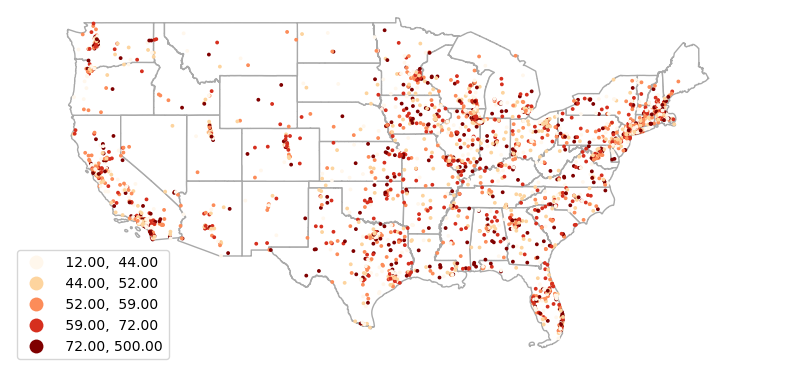

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
gdf_states.plot(ax=ax, color="white", edgecolor="darkgrey")
gdf_us.plot(ax=ax, column='AQI Value', legend=True, cmap='OrRd', marker='o', markersize=3, scheme='quantiles')
ax.set_xlim(-130, -60)
ax.set_ylim(23, 50)
ax.set_axis_off();

Next, a collection of hexbin subplots following the BuGn colormap that, through using latitude and longitude as y and x values respectively, manage to approximate the shape of the United States. We expect for the distribution of color for 'AQI Value' and 'PM2.5 AQI' to appear very similar to each other. 

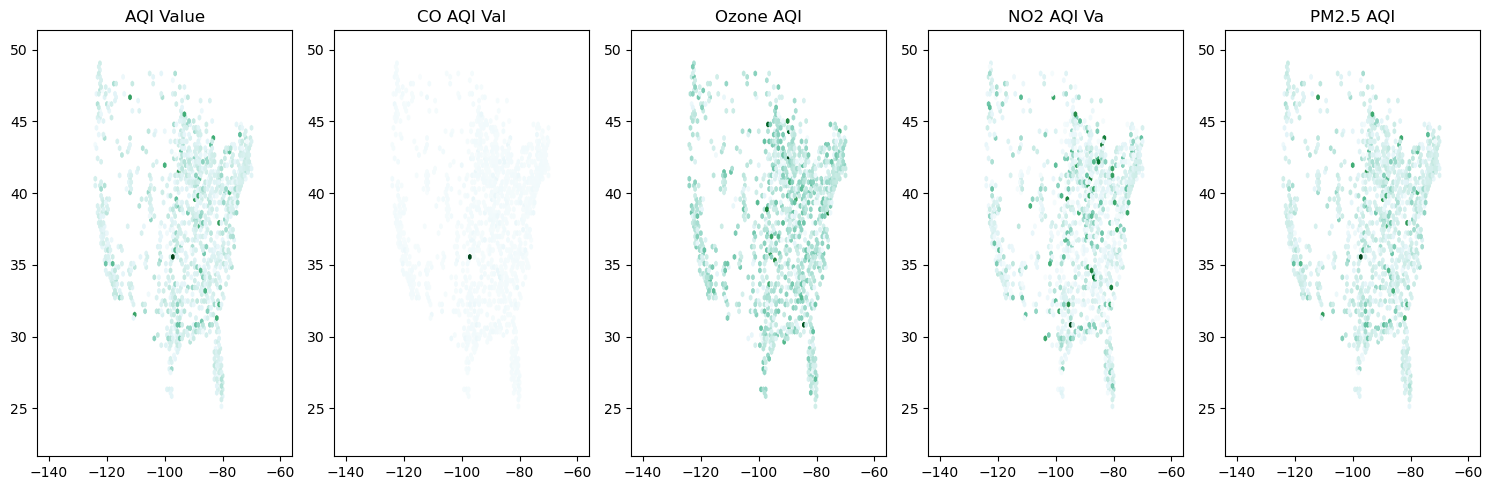

In [8]:
AQI_list = ['AQI Value', 'CO AQI Val', 'Ozone AQI', 'NO2 AQI Va', 'PM2.5 AQI']
fig = plt.figure(figsize=(15,5))
for i in range(len(AQI_list)):
    plt.subplot(1, 5, i+1)
    plt.title(AQI_list[i])
    plt.hexbin(x=gdf_us['lng'], y=gdf_us['lat'], C=gdf_us[AQI_list[i]], gridsize=100, extent=[-140, -60, 23, 50], cmap='BuGn')
plt.tight_layout()
plt.show()

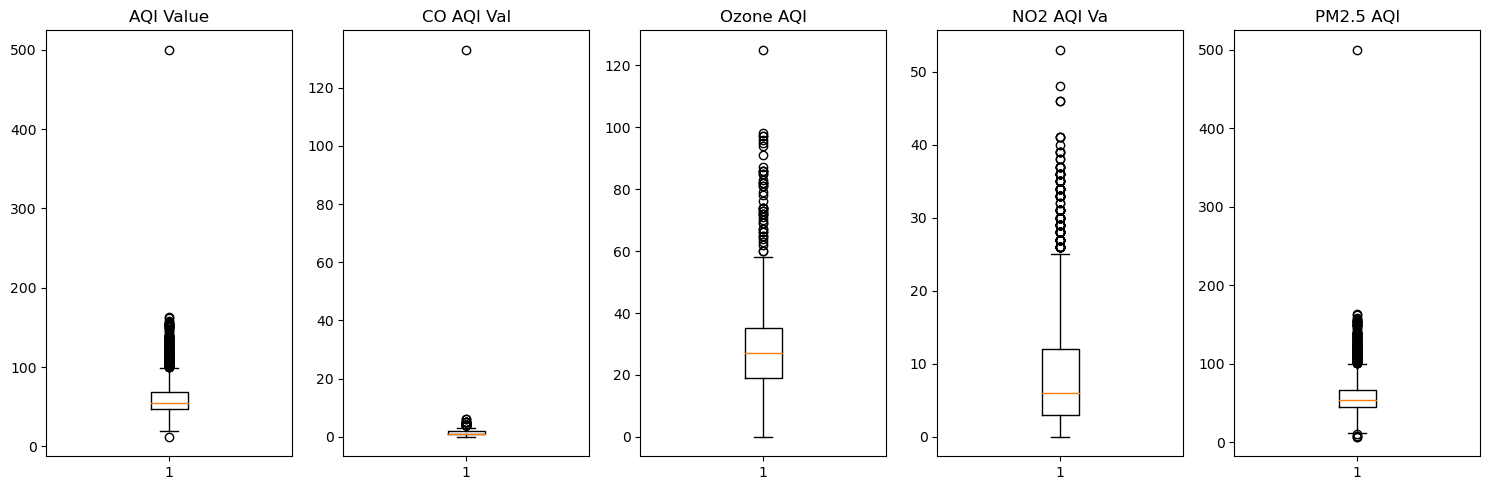

In [9]:
fig = plt.figure(figsize=(15,5))
for i in range(len(AQI_list)):
    plt.subplot(1, 5, i+1)
    plt.title(AQI_list[i])
    plt.boxplot(x=gdf_us[AQI_list[i]])
plt.tight_layout()
plt.show()

Next, to fully explore the relationship between particulates and air quality index, I import the worldwide air pollution dataset.

In [10]:
df = pd.read_csv('datasets/global air pollution dataset.csv')

Running some preliminary analysis

In [11]:
df.describe()

AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
count  23463.000000  23463.000000     23463.000000   23463.000000   
mean      72.010868      1.368367        35.193709       3.063334   
std       56.055220      1.832064        28.098723       5.254108   
min        6.000000      0.000000         0.000000       0.000000   
25%       39.000000      1.000000        21.000000       0.000000   
50%       55.000000      1.000000        31.000000       1.000000   
75%       79.000000      1.000000        40.000000       4.000000   
max      500.000000    133.000000       235.000000      91.000000   

       PM2.5 AQI Value  
count     23463.000000  
mean         68.519755  
std          54.796443  
min           0.000000  
25%          35.000000  
50%          54.000000  
75%          79.000000  
max         500.000000

In [12]:
df.corr()

AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
AQI Value         1.000000      0.430602         0.405310       0.231758   
CO AQI Value      0.430602      1.000000         0.145724       0.488092   
Ozone AQI Value   0.405310      0.145724         1.000000      -0.181818   
NO2 AQI Value     0.231758      0.488092        -0.181818       1.000000   
PM2.5 AQI Value   0.984327      0.438557         0.339887       0.260127   

                 PM2.5 AQI Value  
AQI Value               0.984327  
CO AQI Value            0.438557  
Ozone AQI Value         0.339887  
NO2 AQI Value           0.260127  
PM2.5 AQI Value         1.000000

Experimenting with linear models

In [13]:
model = LinearRegression()
ind = df[['PM2.5 AQI Value']]
dep = df['AQI Value']
model.fit(ind, dep)
df['Predicted AQI Value'] = model.predict(ind)
df.head(5)

Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        Praskoveya         51     Moderate             1   
1              Brazil  Presidente Dutra         41         Good             1   
2               Italy   Priolo Gargallo         66     Moderate             1   
3              Poland         Przasnysz         34         Good             1   
4              France          Punaauia         22         Good             0   

  CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
0            Good               36               Good              0   
1            Good                5               Good              1   
2            Good               39               Good              2   
3            Good               34               Good              0   
4            Good               22               Good              0   

  NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  Predicted AQI Value  
0             Good               51           Moderate            54.369554  
1             Good               41               Good            44.300170  
2             Good               66           Moderate            69.473631  
3             Good               20               Good            23.154463  
4             Good                6               Good             9.057326

In [14]:
rmse = np.sqrt(sklearn.metrics.mean_squared_error(df['AQI Value'], df['Predicted AQI Value']))
r_squared = sklearn.metrics.r2_score(df['AQI Value'], df['Predicted AQI Value'])
print(rmse, r_squared)

9.885420391544011 0.9688988341241522


In [28]:
features = ['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']
ind = df[features]
dep = df['AQI Value']
train_ind, val_ind, train_dep, val_dep = train_test_split(ind, dep)
model = LinearRegression()
model.fit(train_ind, train_dep)
predictions = model.predict(val_ind)
rmse = np.sqrt(sklearn.metrics.mean_squared_error(val_dep, predictions))
r_squared = sklearn.metrics.r2_score(val_dep, predictions)
print(rmse, r_squared)

1.4581414474170792e-14 1.0
